## 线性回归从0开始实现

#### 包括流水线、模型、损失函数和小批量随机梯度下降优化器

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

### 首先根据一个带有噪声的线性模型构建一个人造数据集

In [2]:
def synthetic_data(w, b, num_examples):
    #生成 y = Xw + b + 噪声
    x = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(x, w) + b
    y += torch.normal(0, 0.1, y.shape)
    return x, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2

features, labels = synthetic_data(true_w, true_b, 1000)

In [4]:
print("features: ", features[0], "labels: ", labels[0])

features:  tensor([-1.3177,  0.2512]) labels:  tensor([0.7248])


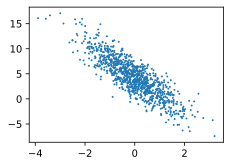

In [11]:
d2l.set_figsize()
d2l.plt.scatter(features[:,1].detach().numpy(), 
               labels.detach().numpy(),1);

### 定义一个data_iter函数，该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量

In [14]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    #样本随机读取，没有顺序
    random.shuffle(indices)
    
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        
        yield features[batch_indices], labels[batch_indices]
        

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-1.2335, -1.1080],
        [ 0.6131, -0.7798],
        [-0.2928,  0.0373],
        [-0.8704, -0.8133],
        [ 2.1206, -0.8839],
        [-1.7905, -2.0567],
        [-0.7025,  0.2683],
        [-0.3753, -0.9522],
        [-0.6911,  1.5804],
        [ 0.5537, -1.0321]]) 
 tensor([[ 5.6187],
        [ 7.9658],
        [ 3.3573],
        [ 5.1415],
        [11.5267],
        [ 7.6673],
        [ 2.0427],
        [ 6.8176],
        [-2.5435],
        [ 8.6521]])


### 初始化模型参数

In [16]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

### 定义模型

In [17]:
def linreg(X, w, b):
    """线性回归"""
    return torch.matmul(X, w) + b

### 定义损失函数

In [18]:
def squared_loss(y_hat, y):
    """均方误差"""
    return (y_hat-y.reshape(y_hat.shape))**2 / 2

### 定义优化算法

In [25]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            #梯度清零
            param.grad.zero_()

In [26]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        
        l.sum().backward()
        sgd([w, b], lr, batch_size)
        
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f"epoch {epoch + 1}, loss {float(train_l.mean()):f}")
            
    

epoch 1, loss 0.030534
epoch 2, loss 0.005280
epoch 3, loss 0.005172


In [27]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0019, -0.0042], grad_fn=<SubBackward0>)
b的估计误差: tensor([-0.0023], grad_fn=<RsubBackward1>)


## 线性回归的简洁实现

In [28]:
import numpy as np
import torch 
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [29]:
def load_array(data_arrays, batch_size, is_train=True):  
    """构造一个PyTorch数据迭代器。"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [31]:
next(iter(data_iter))

[tensor([[-0.9128, -0.1045],
         [-0.3315, -0.0090],
         [-2.3875, -0.1415],
         [ 0.6421,  0.5634],
         [-0.2382, -0.4006],
         [ 0.1205, -0.9328],
         [-0.0390, -0.0228],
         [-0.2058,  0.4509],
         [-1.5060, -0.9691],
         [-0.2962,  0.6112]]),
 tensor([[ 2.7385],
         [ 3.5706],
         [-0.0957],
         [ 3.5877],
         [ 5.0809],
         [ 7.6091],
         [ 4.2131],
         [ 2.2533],
         [ 4.4742],
         [ 1.5265]])]

In [32]:
# 使用定义好的层

from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

### 初始化模型的参数

In [33]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

### 计算使用均方误差， 又称平方L2范数

In [34]:
loss = nn.MSELoss()

### 实例化SGD实例

In [35]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [36]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000240
epoch 2, loss 0.000102
epoch 3, loss 0.000101
